# Analysis on Wine Terroir

**Andrew Lemke**

**Causal Machine Learning Summer 2022**

In [1]:
# data processing
import pandas as pd
import numpy as np
import re
import math
import scipy.stats
from scipy import stats

# causal modeling
import dowhy
from dowhy import CausalModel
from dowhy import gcm

# making and drawing graphs
import graphviz
import networkx as nx
import matplotlib.pyplot as plt

# double ml estimation
import econml
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor


from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier

## Wine Terroir

Terroir (tear - waar) is the word in winemaking to describe the conditions that surround the grapes. There's a reason why places like California and Argentina make wine and Kansas and Colombia don't. Many factors contribute to depthless complexity of wine--soil, sunlight, temperature range, growing and pruning practices.

The data available includes information from the region of production, the weather, scientific measures of the wine, an expert assigned recommendation level, and a description of the tasting qualities of the wine, which indicates if a wine is flat or not. 

This dataset also contains records for the fixed and volatile acidity in the wines. Fixed acidity comes from the grapes and the way they are grown, volatile acidity is a product of the production. Both have an effect on the wine's taste and thus its quality.

**The Causal Question:  What will be the change in expected value for the wine's recommendation if we intervene on the fixed acid?**


## Data

The data processing was performed in another notebook. Consult the data processing if you wish, but it is not necessary. Here, we load the pickled processed dataframe.




In [2]:
data = pd.read_pickle(r'../data/processed_wine_terroir.pickle')

In [3]:
data.head()

,Table.No.,Cultivar,Color,Recommend,Reg,Harvest date,Brix,Must.Tacid,pH,Alcohol,...,RegionYearKey,Year,GST,WI,HI,Vacid,Flat,RecommendNum,Outsider,RegNum
0,9,Chardony,White,Particularly recommended,3,1936-09-08,27.2,0.54,3.88,15.6,...,"(3, 1936)",1936.0,19.786041,2094.212862,1863.399599,0.12,0,3,0,3
1,9,Chardony,White,Particularly recommended,1,1937-10-01,22.1,0.72,3.38,12.0,...,"(1, 1937)",1937.0,17.749533,1659.250000,1442.339476,0.20,0,3,0,1
2,9,Chardony,White,Particularly recommended,3,1937-09-11,24.6,0.63,3.69,12.8,...,"(3, 1937)",1937.0,19.207009,1970.550000,1746.845970,0.14,1,3,0,3
3,9,Chardony,White,Particularly recommended,1,1938-09-14,19.8,0.78,3.19,10.5,...,"(1, 1938)",1938.0,16.971930,1492.843091,1320.823747,0.10,0,3,0,1
4,9,Chardony,White,Particularly recommended,3,1938-09-25,25.2,0.62,3.34,14.8,...,"(3, 1938)",1938.0,18.348832,1788.550000,1635.055914,0.03,0,3,0,3


In [4]:
n = len(data)
print(n)

1055


## Model

The three weather indices cover the same information, the temperature. We will select just the Huglin Index to represent this variable.




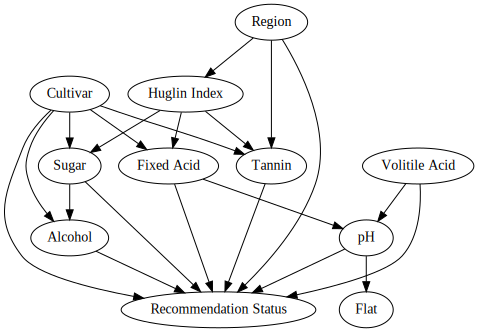

In [5]:
dot_bin = graphviz.Digraph('DAG')

dot_bin.node('Cultivar')
dot_bin.node('RecommendNum', 'Recommendation Status')
dot_bin.node('RegNum', 'Region')
#dot_bin.node('GST', 'Growing Ssn Avg Temp')
#dot_bin.node('WI', 'Winkler Index')
dot_bin.node('HI', 'Huglin Index')
dot_bin.node('Facid', 'Fixed Acid')
dot_bin.node('Vacid', 'Volitile Acid')
dot_bin.node('Alcohol')
dot_bin.node('Brix', 'Sugar')
#dot.node('Extract')  # not relivant for taste
dot_bin.node('Tannin')
dot_bin.node('Flat')
dot_bin.node('pH')


dot_bin.edges([
           #('RegNum', 'GST'),
           #('RegNum', 'WI'), 
           ('RegNum', 'HI'),
           ('RegNum', 'Tannin'),
           ('Facid', 'RecommendNum'), 
           #('WI', 'Vacid'),
           #('GST', 'Vacid'), 
           ('HI', 'Facid'),
           ('Vacid', 'RecommendNum'),
           ('Tannin', 'RecommendNum'), 
           ('Cultivar', 'Tannin'),
           ('Cultivar', 'Facid'), 
           ('Cultivar', 'RecommendNum'),
           ('Cultivar', 'Alcohol'),
           ('Alcohol', 'RecommendNum'), 
           ('Cultivar', 'Brix'), 
           ('Brix', 'RecommendNum'),
           #('WI', 'Brix'),
           #('GST', 'Brix'), 
           ('HI', 'Brix'),
           ('Brix', 'Alcohol'),
           ('Facid', 'pH'),
           ('Vacid', 'pH'),
           ('pH', 'RecommendNum'),
           ('pH', 'Flat'),
           #('WI', 'Tannin'),
           #('GST', 'Tannin'), 
           ('HI', 'Tannin'),
           ('RegNum', 'RecommendNum')
           ])

dot_bin

DoWhy's causal model takes in a modified dot format. The from the text of the source, "DAG" needs to be removed. In addition, all newlines need to be replaced with semicolons except for the newline after the opening brace. Tabs must be removed too.

In [6]:
modified_dot_bin = dot_bin.source.replace(' DAG', '').replace('\n', ';').replace('\t', '').replace('{;C', '{C')

In [7]:
# simplify data by removing unneeded columns
roots = ['Cultivar', 'RegNum']
non_roots = ['RecommendNum', 'Flat', 'Brix', 'pH', 'Alcohol', 'Facid', 'Vacid', 'Tannin', 'HI']
data_for_model = data[roots + non_roots]
#data_for_model['HI'] = (data_for_model['HI'] > 1875).astype(int)

In [8]:
model_recommend_bin = CausalModel(
    data=data_for_model,
    treatment='Facid',
    outcome='RecommendNum',
    graph=modified_dot_bin
)

### Why not just look at fixed acid and recommendation level?

It seems like an easy answer to our question. We can easily calculate the fixed acid for the highly rated and poorly rated wines.

In [9]:
data['Facid'].loc[data['RecommendNum'] >= 2].mean()

In [10]:
data['Facid'].loc[data['RecommendNum'] < 2].mean()

One could see this as evidence that higher fixed acid leads to more highly recommended wines. This is not allowed, however. Looking at the graph, we can see many paths for association to propagate between fixed acidity and recommendation level. Could the cultivar be the true causal source, where good grapes just happen to have high fixed acid, and this fixed acid is irrelevant compared to the impact of the grape? **We cannot isolate the effect of fixed acid without an intervention.**

## **2. Identify**

Identification by hand is possible, but DoWhy has an automated identifier that tells us if we can compute the causal effect by looking at the DAG. Gives results for backdoor, front door and IV identification.

We can see from the graph that there are several common causes for fixed acid and the recommendation level, so we know we can use the back door. Unfortunately, IV is closed off, and no mediators exist. In complicated and densely connected graphs, backdoor is usually the only option.


In [11]:
identified_estimand_regbin = model_recommend_bin.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand_regbin)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                 
────────(E[RecommendNum|HI,Cultivar])
d[Facid]                             
Estimand assumption 1, Unconfoundedness: If U→{Facid} and U→RecommendNum then P(RecommendNum|Facid,HI,Cultivar,U) = P(RecommendNum|Facid,HI,Cultivar)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



## **3. Estimate**


### Estimations for recommendation as the output

Double ML is a very strong option here. It can handle the complexity of the situation well. We have many continuous or higher level categorical variables, but ML models can perform well on accuracy and compute time.

In [12]:
model = model_recommend_bin
identified_estimand = identified_estimand_regbin

In [13]:
rs = 1

dml_estimate_recreg = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.econml.dml.DML",
    control_value = .40,
    treatment_value = .54,
    method_params={
        "init_params":{
            'model_y':GradientBoostingRegressor(n_estimators=1000, max_depth=10, min_impurity_decrease=0.05, random_state=rs),
            'model_t': GradientBoostingRegressor(n_estimators=1000, max_depth=10, min_impurity_decrease=0.05, random_state=rs),
            "model_final":LassoCV(fit_intercept=False, tol=0.003, max_iter=100000, random_state=rs),
            'featurizer':PolynomialFeatures(degree=1, include_bias=False)
        },
        "fit_params":{}
    }
)

print(dml_estimate_recreg)
print("The causal effect estimate is " + str(round(dml_estimate_recreg.value, 4)))

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                 
────────(E[RecommendNum|HI,Cultivar])
d[Facid]                             
Estimand assumption 1, Unconfoundedness: If U→{Facid} and U→RecommendNum then P(RecommendNum|Facid,HI,Cultivar,U) = P(RecommendNum|Facid,HI,Cultivar)

## Realized estimand
b: RecommendNum~Facid+HI+Cultivar | Tannin,Vacid,Brix,Alcohol
Target units: ate

## Estimate
Mean value: 0.10411681708203059
Effect estimates: [0.12395548 0.10071383 0.1121068  ... 0.09934667 0.10344814 0.08020649]

The causal effect estimate is 0.1041


Our result is a causal effect 0.1041*. This value is the expectation of the wine output when using the treatment value minus our expectation with the control. In this case, we see that higher fixed acidity causes higher ratings in wine.

\* will vary on subsequent runs

## **4. Refutation**

As mentioned when describing the four-step process, refutation helps us ensure our model is robust. 


### Random common cause

Adding a random common cause should not change the effect we have calculated.

In [14]:
# Avoiding unnecessary log messges and warnings
import logging
logging.getLogger("dowhy").setLevel(logging.WARNING)
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [15]:

res_random = model.refute_estimate(
    identified_estimand_regbin, 
    dml_estimate_recreg, 
    method_name="random_common_cause",
    num_simulations=5
)
print(res_random)

Refute: Add a random common cause
Estimated effect:0.10411681708203059
New effect:0.10885718259662194
p value:0.3007541645223958



### Placebo refutation

In [16]:
res_placebo=model.refute_estimate(
    identified_estimand_regbin,
    dml_estimate_recreg,
    method_name="placebo_treatment_refuter",
    placebo_type="permute",
    num_simulations=20
)
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:0.10411681708203059
New effect:-0.0005904564633562816
p value:0.4802432028433161



We see that the difference between the estimated and new effect is low, just .004, supporting our model. In the placebo refutation, the new effect is 0.001, meaning our model's estimated effect is 0 when our treatment variable is set randomly. These both support that our model is solid, even though it does not encapsulate every variable in wine making. When modeling, we know we must make certain assumptions. In this case, these assumptions are forced by the limits of the data. We used all available and relevant features, but more would have been nice. The limit both in quantity of instances and features is likely due to cost.



## Conclusion

Wine quality is increased due to higher fixed acid amounts. We used a causal model, which was created by domain knowledge, to model the data generation process. Using this causal generative model, we performed an intervention using the double ML estimator to find that the expectation for a wine's quality increases by .104 when using a treatment value of 0.54 g/100cc compared to a control value of 0.40 g/100cc for fixed acid. The wine quality scale is from 0 to 3. Refutation confirms the validity of our model.

Simple association is not enough to determine causality; you must use a causal model instead. Constructing one and performing the 4 steps necessary to ask causal questions leads to more important conclusions that naturally mesh with human though, which works in cause and effect, not "statistical association."


# References

* Drawing software for DAGs in explaination sections
  + http://dagitty.net/dags.html#

* Wine Terroir Dataset
  + article: https://www.nature.com/articles/s41597-022-01367-6
  + data download: https://figshare.com/articles/dataset/data/19807777/1

* Wine research
  + https://www.compoundchem.com/2014/05/28/redwinechemicals/#:~:text=In%20general%2C%20red%20wine%20is,different%20compounds%20to%20over%201000.
  + https://www.hospitalitynet.org/opinion/4094843.html#:~:text=As%20part%20of%20a%20process,alcohol%20levels%20in%20the%20wine.
  + https://www.goldmedalwineclub.com/blog/post/the-gritty-truth-why-is-there-sediment-in-my-wine#:~:text=Sediment%20is%20a%20byproduct%20of,%2C%20and%20crystal%2Dlike%20tartrates.
  + https://www.nature.com/articles/s41597-022-01367-6#ref-CR29
  + https://daily.sevenfifty.com/the-science-of-tannins-in-wine/
  + https://usualwines.com/blogs/knowledge-base/is-wine-acidic#:~:text=Low%2Dacid%20reds%20such%20as,acidity%20naturally%20in%20the%20bottle.
  + https://winemakermag.com/article/cellar-dwellers-4#:~:text=White%20grapes%20are%20generally%20harvested,of%2012.1%E2%80%9314.3%25%20ABV.
  + https://coolmaterial.com/food-drink/climate-change-whiskey-wine-beer/#:~:text=Climate%20change%20is%20also%20causing,the%20wine%2C%20making%20more%20alcohol.
  + https://waterhouse.ucdavis.edu/whats-in-wine/fixed-acidity#:~:text=The%20predominant%20fixed%20acids%20found,2%2C000%20mg%2FL%20succinic%20acid.
  + https://www.webmd.com/diet/what-to-know-sulfites-in-wine
  + https://link.springer.com/article/10.1007/s00706-019-02454-y

* Documentation from
  + Pandas
  + DoWhy
  + Sklearn
  + Graphviz